# EMG data processing

EMG is electromyography, procedure used to obtain myoelectric data. This are recording of signals used by motor neurons to cause muscles to contratc (more information [here](https://www.mayoclinic.org/tests-procedures/emg/about/pac-20393913)).

This signals are frequently used in bionic prosthetics development. More information on myoelectric pattern recognition for bionic upper limb prosthetics [here](https://bionicsforeveryone.com/myoelectric-pattern-recognition-bionic-arms-hands/).

More references and sources are available in [README](../README.md).

Special Thanks go to [BioPatRec](https://github.com/biopatrec/biopatrec/wiki/BioPatRec.md) team for making EMG data sets available for free access on the web.

### Preparations.

Installing and importing required libraries.

In [398]:
# ! pip3 install numpy matplotlib scipy
# ! pip3 install sklearn

In [384]:
import math
import numpy as np
import scipy as sp
from scipy import signal
from scipy.io import loadmat
import matplotlib.pyplot as plt

Helper functions.

In [408]:
def plot_signal_amplitude_spectrum(s, time, signal_name, Fd):
    # Signal in Time domain
    fig, axs = plt.subplots(2, 1, figsize=(10, 7))
    axs[0].plot(time, s)
    axs[0].set(xlabel='Time, s', ylabel='Voltage, mV')
    
    # Amplitude spectrum 
    signal_fft = np.fft.fft(s)
    N = len(signal_fft)
    n = np.arange(N)
    T = N/Fd
    freq = n/T 
    axs[1].stem(freq, np.abs(signal_fft), linefmt='b', basefmt="-b")
    axs[1].set(xlabel='Frequency, Hz', ylabel='Amplitude')
    plt.xlim(-1, Fd/2)
    plt.suptitle(signal_name)
    plt.plot()

def plot_multiple_channel_signal(sig, time, signal_name, image_name="img", save_image=False):
    channels = len(sig)
    fig, axs = plt.subplots(channels, 1, figsize=(14, channels*6))
    
    for i in range(channels):
        axs[i].plot(time, sig[i])
        axs[i].set(xlabel='Time, s', ylabel='Voltage, mV', title=f'Channel {i+1}')

    plt.suptitle(signal_name)
    plt.show()
    
    if save_image:
        fig.set_size_inches(w=14,h=channels*6)
        fig.savefig(image_name+".png", facecolor="lightgray") 

### Downloading demonstration EMG data.

In this project I will use data, provided by [BioPatRec](https://github.com/biopatrec/biopatrec).

To be precise, I will use data from this dataset: https://github.com/biopatrec/biopatrec/tree/Data_Repository/10mov4chForearmUntargeted.

(Part of the) info on dataset from https://github.com/biopatrec/biopatrec/wiki/Data_Repository.md:

* 10 hand and wrist motions: Hand Open/Close, Wrist Flex/Extend, Pro/Supination, Fine/Side Grip, Pointer (index extension), Agree or Thumb up
* 3 seconds contraction time with 3 seconds for relaxation between each repetition
* 3 repetitions of each motion
* 4 bipolar electrodes (Disposable Ag/AgCl)
* 20 subjects (final release)
    
* Amplifiers:
    * In-house design (MyoAmpF2F4-VGI8)
    * CMRR > 130 dB
    * Gain 71 dB
    * Embedded active ﬁltering:
        * 4th order high-pass ﬁlter at 20 Hz
        * 2nd order low-pass ﬁlter at 400 Hz
        * Notch ﬁlter at 50 Hz.
    * Galvanic isolation rated to 1,500 Vrms
* Signals were digitized at 2 kHz with a 14-bits resolution.

In [75]:
!wget https://github.com/biopatrec/biopatrec/blob/Data_Repository/10mov4chForearmUntargeted/2.mat

--2021-12-23 21:23:56--  https://github.com/biopatrec/biopatrec/blob/Data_Repository/10mov4chForearmUntargeted/1.mat
Визначення назви github.com (github.com)... 140.82.121.4
Встановлення з'єднання з github.com (github.com)|140.82.121.4|:443... з’єднано.
HTTP-запит надіслано, очікуємо на відповідь… 200 OK
Довжина: не вказано [text/html]
Зберігаємо до `1.mat'

1.mat                   [      <=>           ] 157,20K  70,7KB/s    за 2,2s    

2021-12-23 21:23:59 (70,7 KB/s) - `1.mat' збережено [160972]



**test_data.mat** is actually a renamed 2.mat, so its source is https://github.com/biopatrec/biopatrec/blob/Data_Repository/10mov4chForearmUntargeted/2.mat.

### Reading and saving data.

One file represents data, obtained for one subject (human being to be precise).

We are currently interested in the recSession (recording session) in the data.

This structure containing such important for us info:
* **tdata** –– data itself (the last object), has such structure: (total data, Samples x Channels x Movements). In case of test_data.mat it is (36000, 4, 10). For different datasets number of channels may also vary, as far as I understand it is the number of signals, which were recorded (for example 4 means that person was connected to 4 electrodes in different places). Samples are in mV.
* **sF** –– sampling frequency
* **sT** –– sampling time
* **nCh** –– number of channels
* **dev** –– device used for the recordings
* **mov** –– movements performed (labels, which we gonna use for training)

More about recSession data structure here: https://github.com/biopatrec/biopatrec/wiki/recSession.md

In [168]:
# Load Recording session data from the file
filename = "test_data.mat"
mat = loadmat(filename)
rec_session = mat['recSession']

# Load information from recording session
sF = rec_session['sF'][0][0][0][0]
sT = rec_session['sT'][0][0][0][0]
tdata = rec_session['tdata'][0][0]
nCh = rec_session['nCh'][0][0][0][0]
dev = rec_session['dev'][0][0][0][0][0]
mov_labels = [el[0][0] for el in rec_session['mov'][0][0]]

# Extracting the movements from total data and saving them with according labels
movements_dictionary = dict()
for i in range(len(mov_labels)):
    movements_dictionary[mov_labels[i]] = tdata[:, :, i].transpose()

The dictionary with movements contains them in such arrangement: {'movement name':array(channel 1, channel 2, channel 3, channel 4), ...}

Each channel has with 36000 signal samples (for the file I am currently using).

In [134]:
print("Info about data:")
print(f"\tsampling frequency = {sF} Hz") 
print(f"\tsampling time = {sT} s")
print(f"\tnumber of channels = {nCh}")
print(f"\tsignal recording devise: {dev}")
print("Data contains such movements, as", mov_labels)

Info about data:
	sampling frequency = 2000 Hz
	sampling time = 18 s
	number of channels = 4
	signal recording devise: MyoAmpF4F2
Data contains such movements, as ['Open Hand', 'Close Hand', 'Flex Hand', 'Extend Hand', 'Pronation', 'Supination', 'Side Grip', 'Fine Grip', 'Agree', 'Pointer']


### Data visualization.

Here is an example visualization of a 'Fine Grip' movement (for all 4 channels).

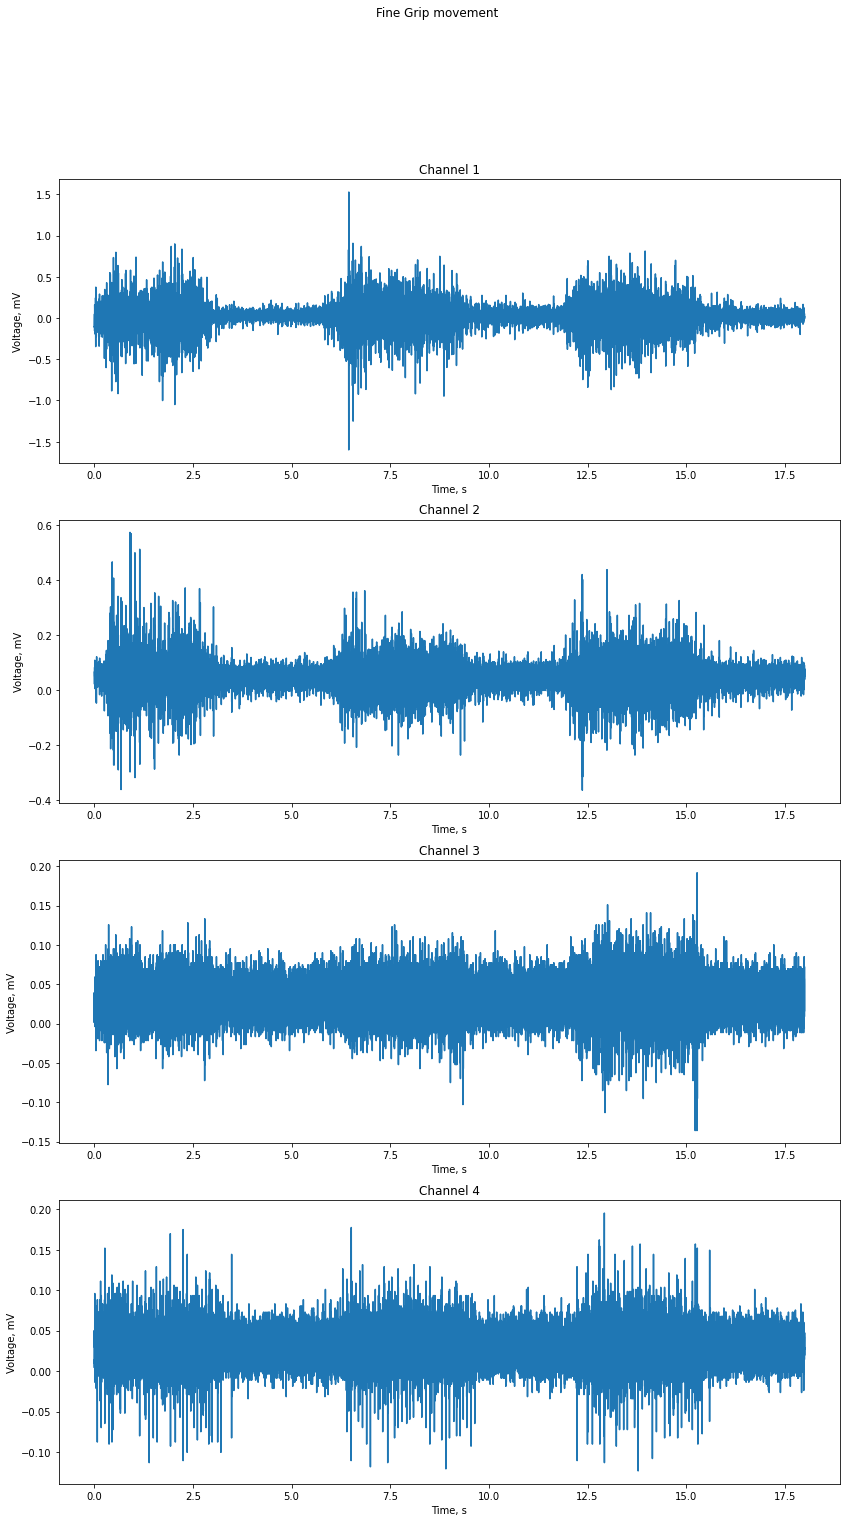

In [167]:
time = np.arange(0, sT, 1/sF)
plot_multiple_channel_signal(movements_dictionary['Fine Grip'], time, 'Fine Grip movement')

Amplitude spectrum for Fine Grip movement (on one channel).

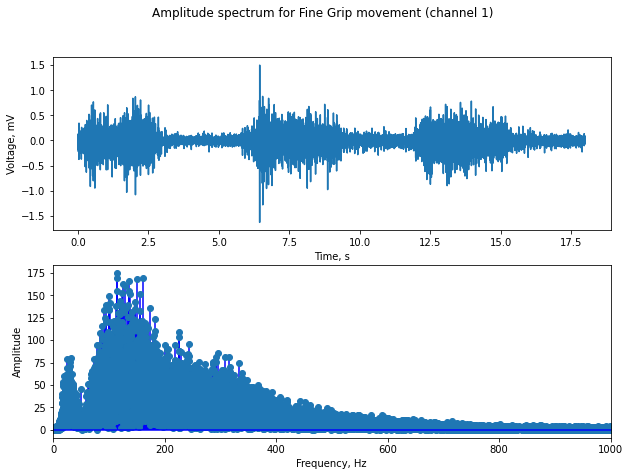

In [203]:
plot_signal_amplitude_spectrum(movements_dictionary['Fine Grip'][0], time, 'Amplitude spectrum for Fine Grip movement (channel 1)', sF)

Spectrogram for better understanding of the data.

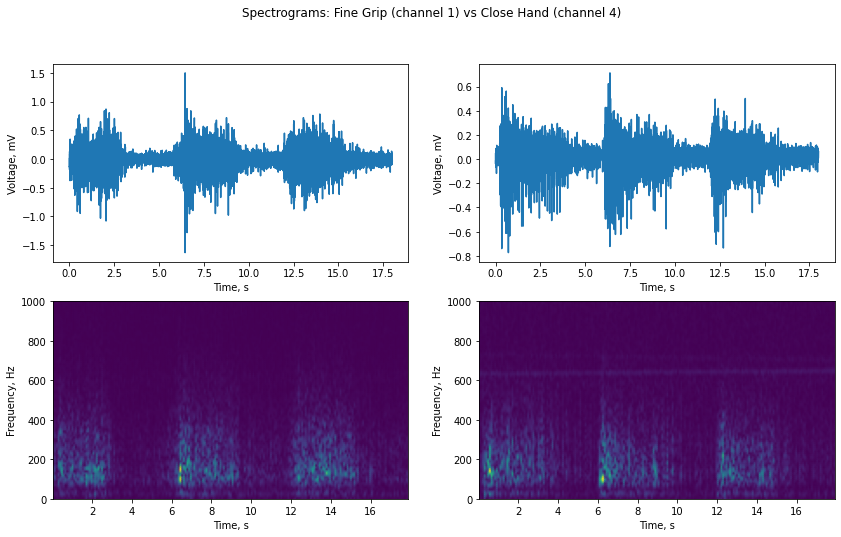

In [400]:
sig = movements_dictionary['Fine Grip'][0]
window = sp.signal.windows.blackmanharris(math.floor(0.1*sF))

fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs[0, 0].plot(time, sig)
axs[0, 0].set(xlabel='Time, s', ylabel='Voltage, mV')

f, t, Sxx = sp.signal.spectrogram(sig, fs=sF, window=window, noverlap=None, mode='magnitude')
axs[1, 0].pcolormesh(t, f, Sxx, shading='gouraud')
axs[1, 0].set(xlabel='Time, s', ylabel='Frequency, Hz')

sig = movements_dictionary['Close Hand'][3]
axs[0, 1].plot(time, sig)
axs[0, 1].set(xlabel='Time, s', ylabel='Voltage, mV')

f, t, Sxx = sp.signal.spectrogram(sig, fs=sF, window=window, noverlap=None, mode='magnitude')
axs[1, 1].pcolormesh(t, f, Sxx, shading='gouraud')
axs[1, 1].set(xlabel='Time, s', ylabel='Frequency, Hz')

plt.suptitle("Spectrograms: Fine Grip (channel 1) vs Close Hand (channel 4)")
plt.show()

It is easy to spot that there are three repetitions of each movement.

Saving image:

In [407]:
fig_name = 'spectrograms.png'
fig.set_size_inches(w=14,h=8)
fig.savefig(fig_name, facecolor="lightgray")

### Processing EMG data.

Signal processing pipeline structure is based on the tutorial from https://scientificallysound.org/2016/08/22/python-analysing-emg-signals-part-4/.

This dataset already contains some preprocessing (4th order high-pass ﬁlter at 20 Hz, 2nd order low-pass ﬁlter at 400 Hz, Notch ﬁlter at 50 Hz), but this is not a complete processing, required for EMG data. 

Processing pipeline will include:
1. Removing mean EMG (making average 0 volts)
2. Rectification (using absolute values of the signal)
3. Butterworth low-pass filter for envelope

Visualization of the pipeline on signal for Fine Grip movement.

In [413]:
def processing_pipeline(sig, time, sF, name="", envelope_low_pass_fr=1, visualize=False):
    """
    Pipeline for signals with multiple channels.
    """
    
    if visualize:
        plot_multiple_channel_signal(sig, time, f'Raw signal: {name}')
        
    # Removing mean EMG (making average 0 volts)
    for i in range(len(sig)):
        sig[i] -= np.mean(sig[i])
    
    if visualize:
        plot_multiple_channel_signal(sig, time, f'Zero-average signal: {name}')
        
    # Rectification (using absolute values of the signal)
    rectified_signal = []
    for i in range(len(sig)):
        rectified_signal.append(abs(sig[i]))
    
    if visualize:
        plot_multiple_channel_signal(rectified_signal, time, f'Rectified signal: {name}')
        
    # Butterworth low-pass filter for envelope
    low_pass_fr = envelope_low_pass_fr/(sF/2)
    b, a = sp.signal.butter(4, low_pass_fr, btype='lowpass')
    final_sig = sp.signal.filtfilt(b, a, rectified_signal)
    
    if visualize:
        plot_multiple_channel_signal(final_sig, time, f'Envelope: {name}')
    
    return final_sig

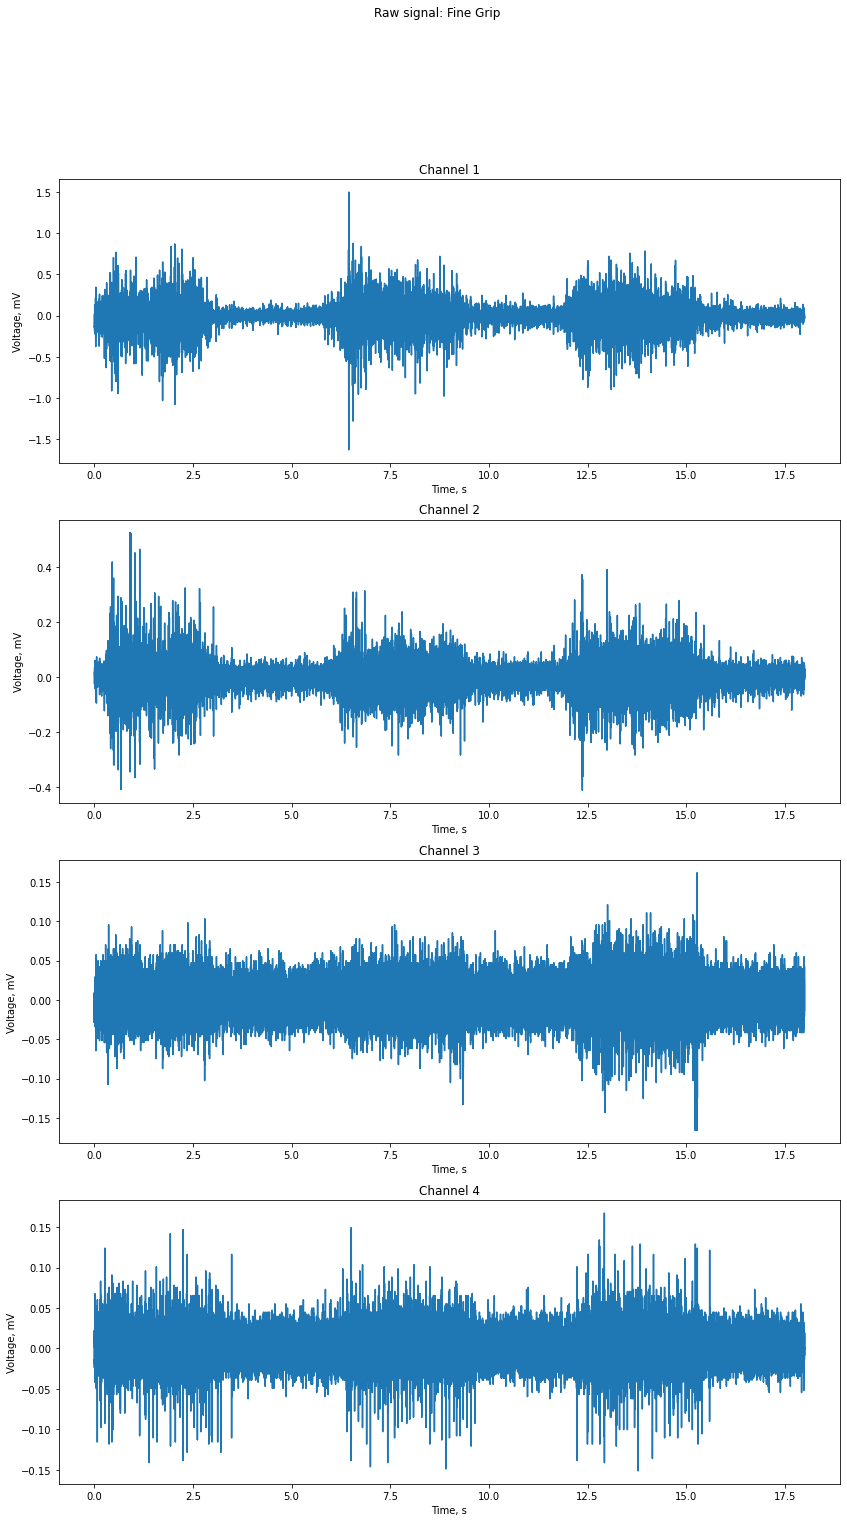

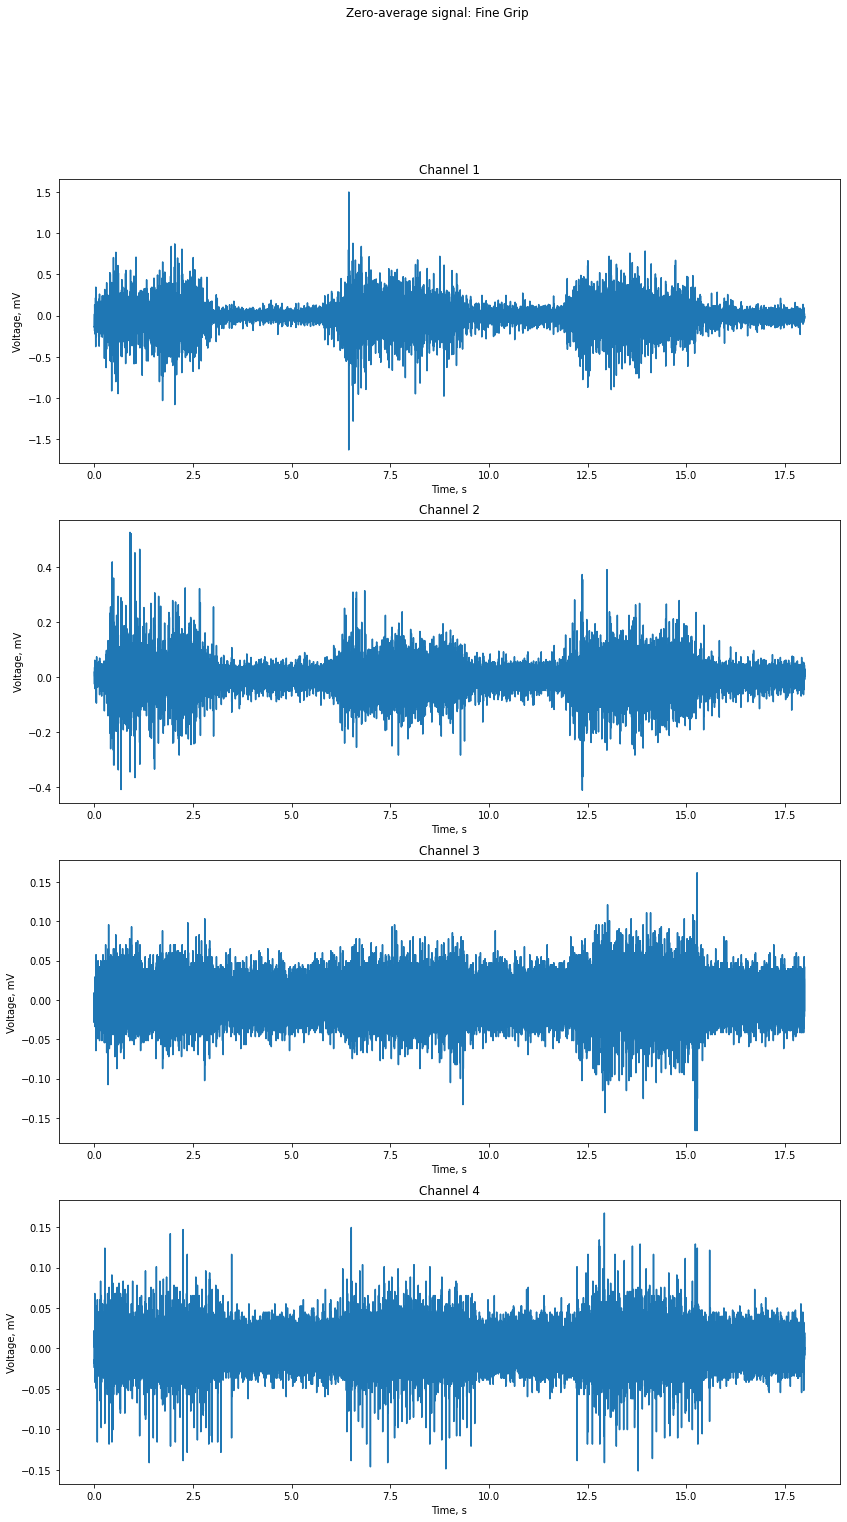

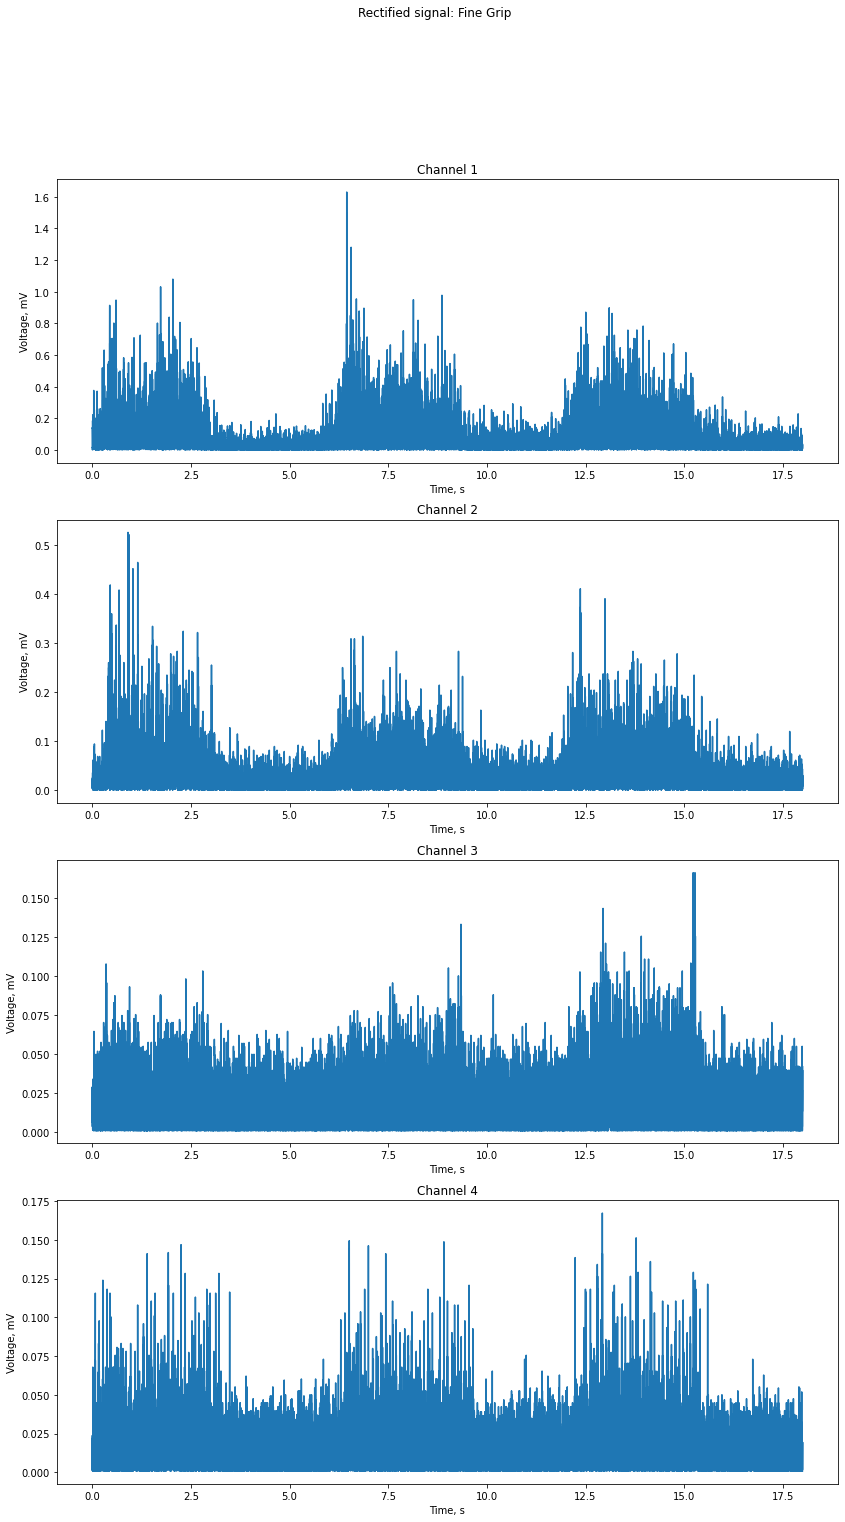

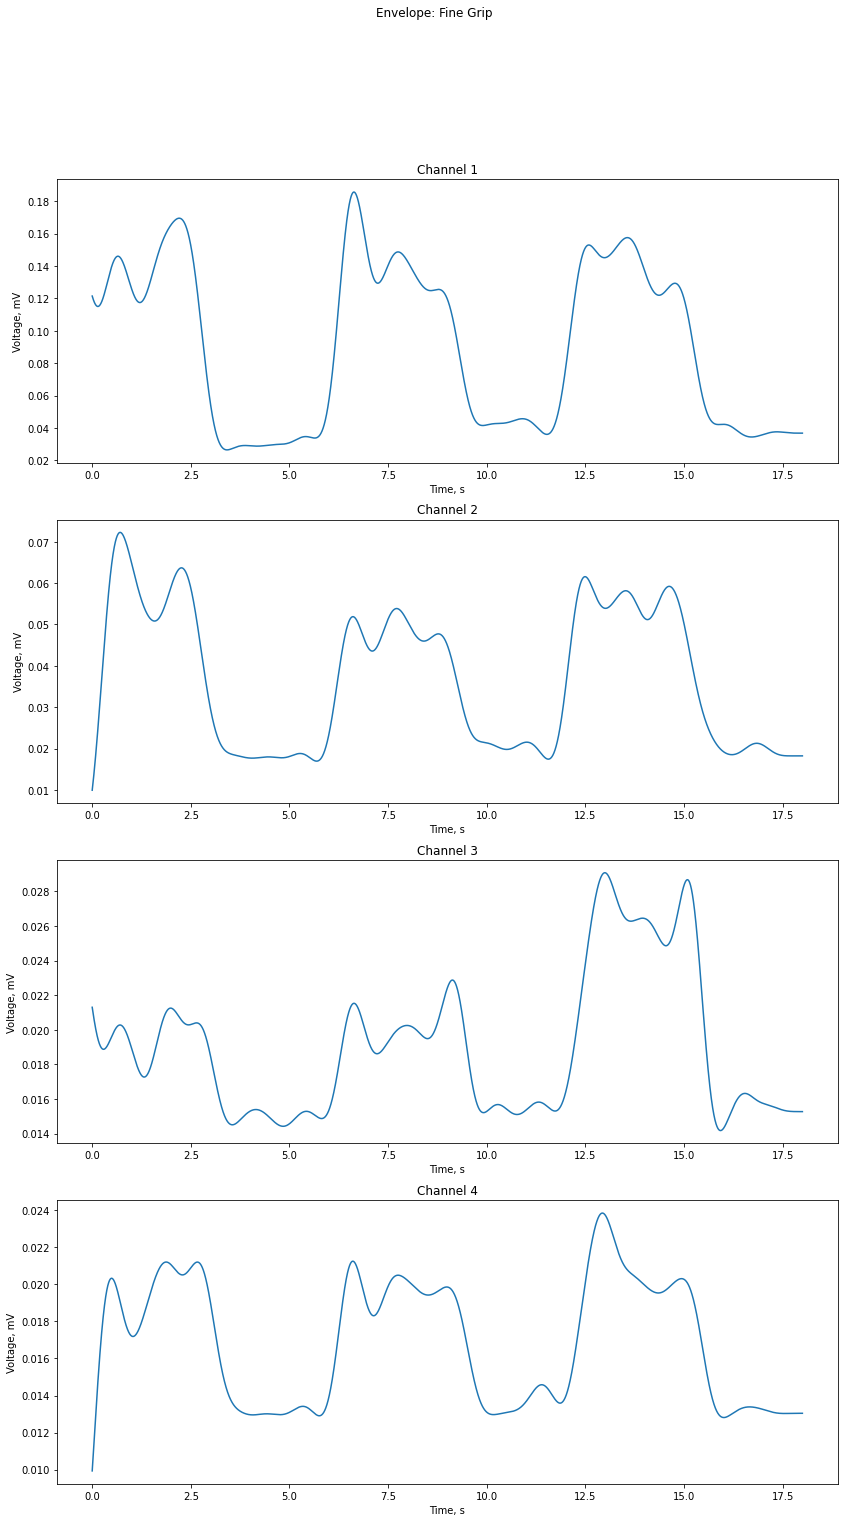

array([[0.1214527 , 0.12141019, 0.1213678 , ..., 0.03677361, 0.03677361,
        0.03677361],
       [0.00993746, 0.00997945, 0.01002152, ..., 0.01824007, 0.01824007,
        0.01824007],
       [0.02130304, 0.02129512, 0.02128721, ..., 0.01526962, 0.01526962,
        0.01526962],
       [0.00993043, 0.0099475 , 0.00996457, ..., 0.01303998, 0.01303998,
        0.01303998]])

In [ ]:
time = np.arange(0, sT, 1/sF) 
test_signal = movements_dictionary['Fine Grip']
processing_pipeline(test_signal, time, sF, 'Fine Grip', 1, visualize=True)

Here is visualization of Open Hand movement processing for comparison.

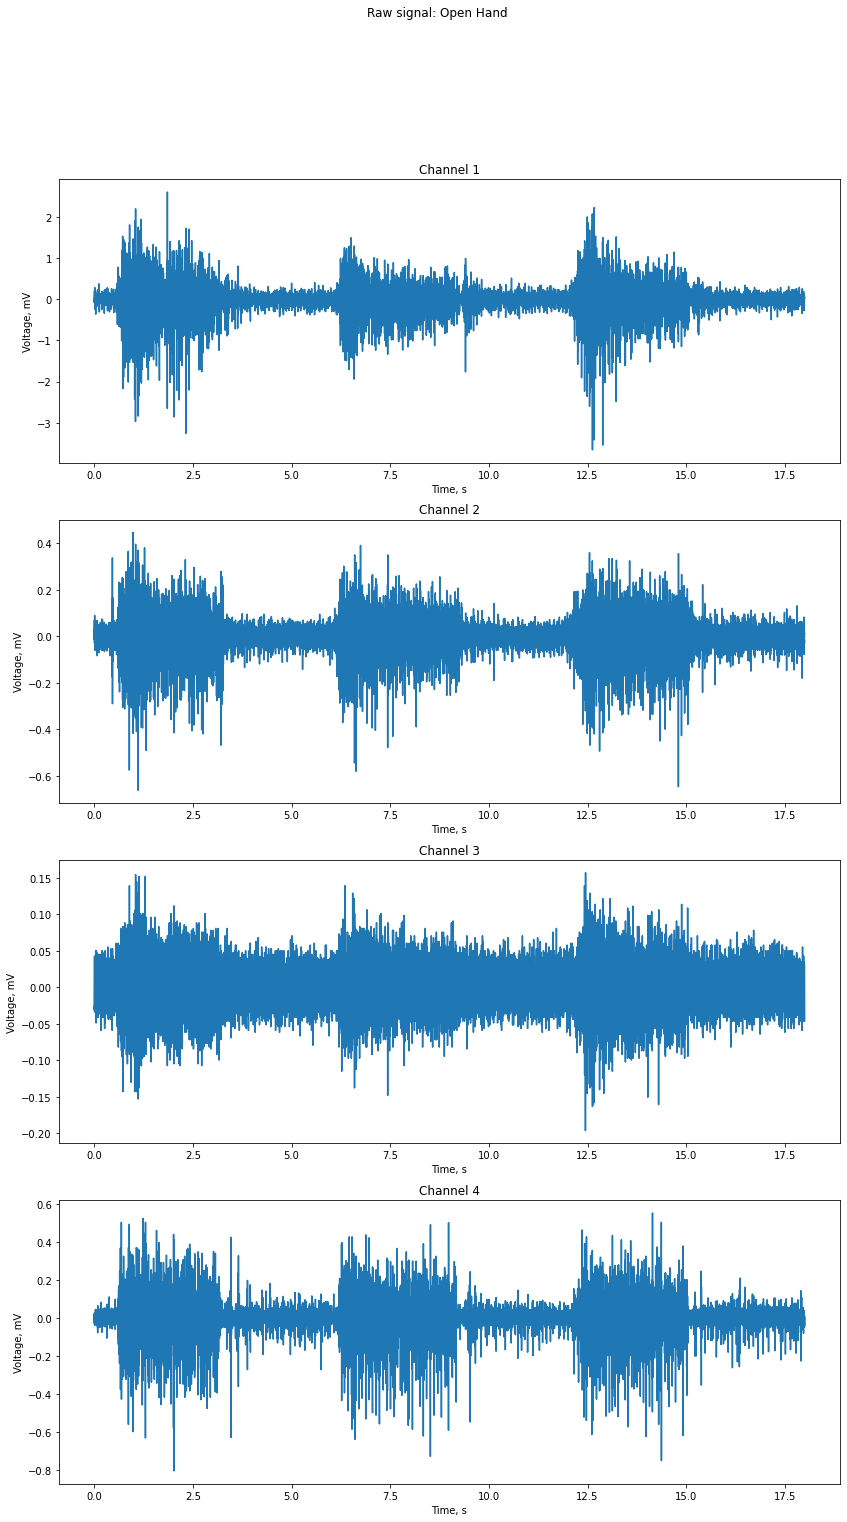

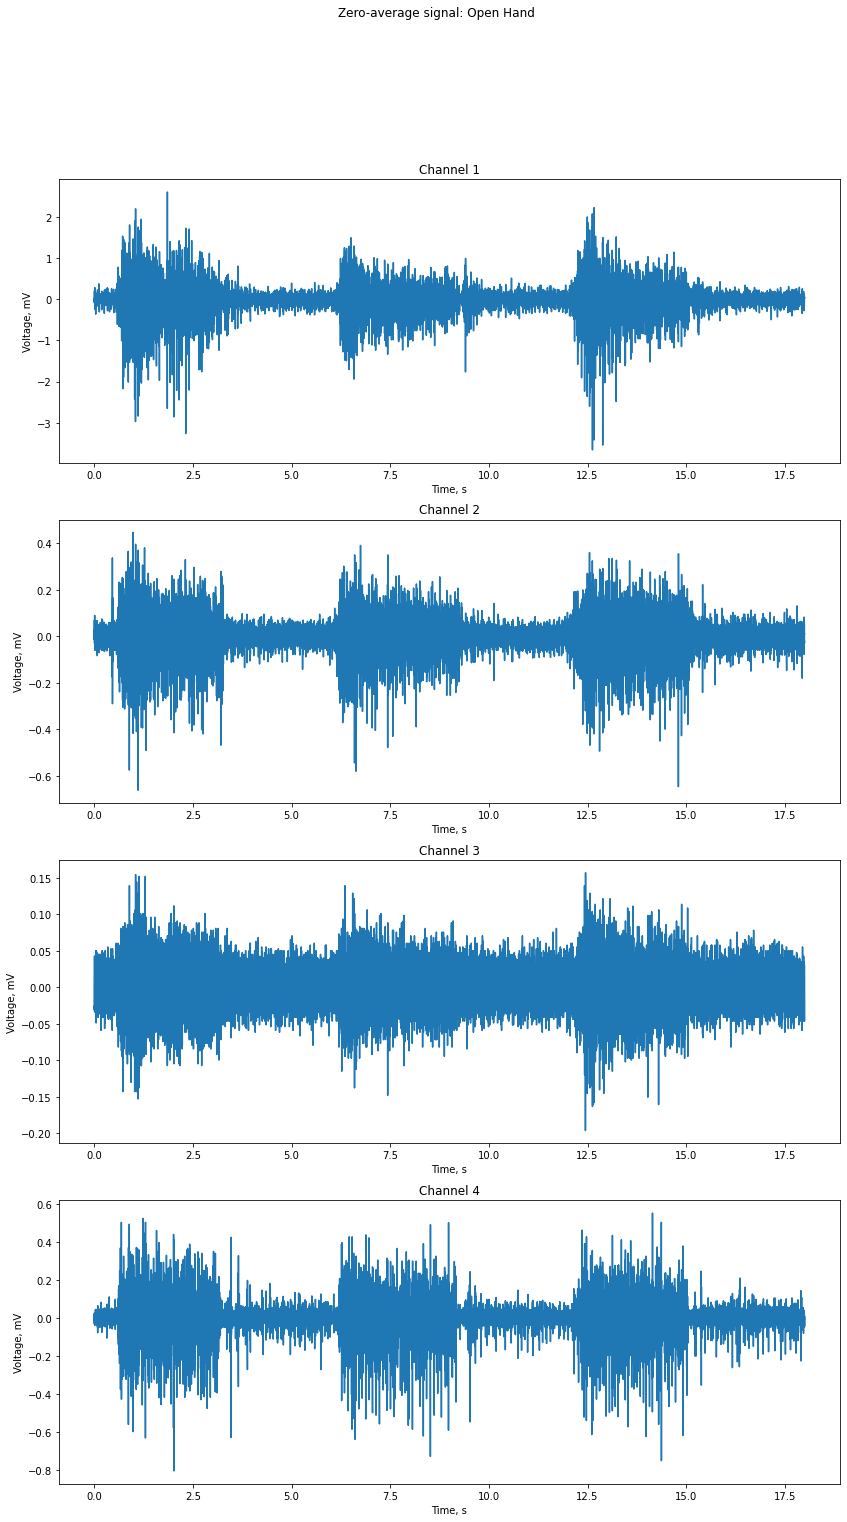

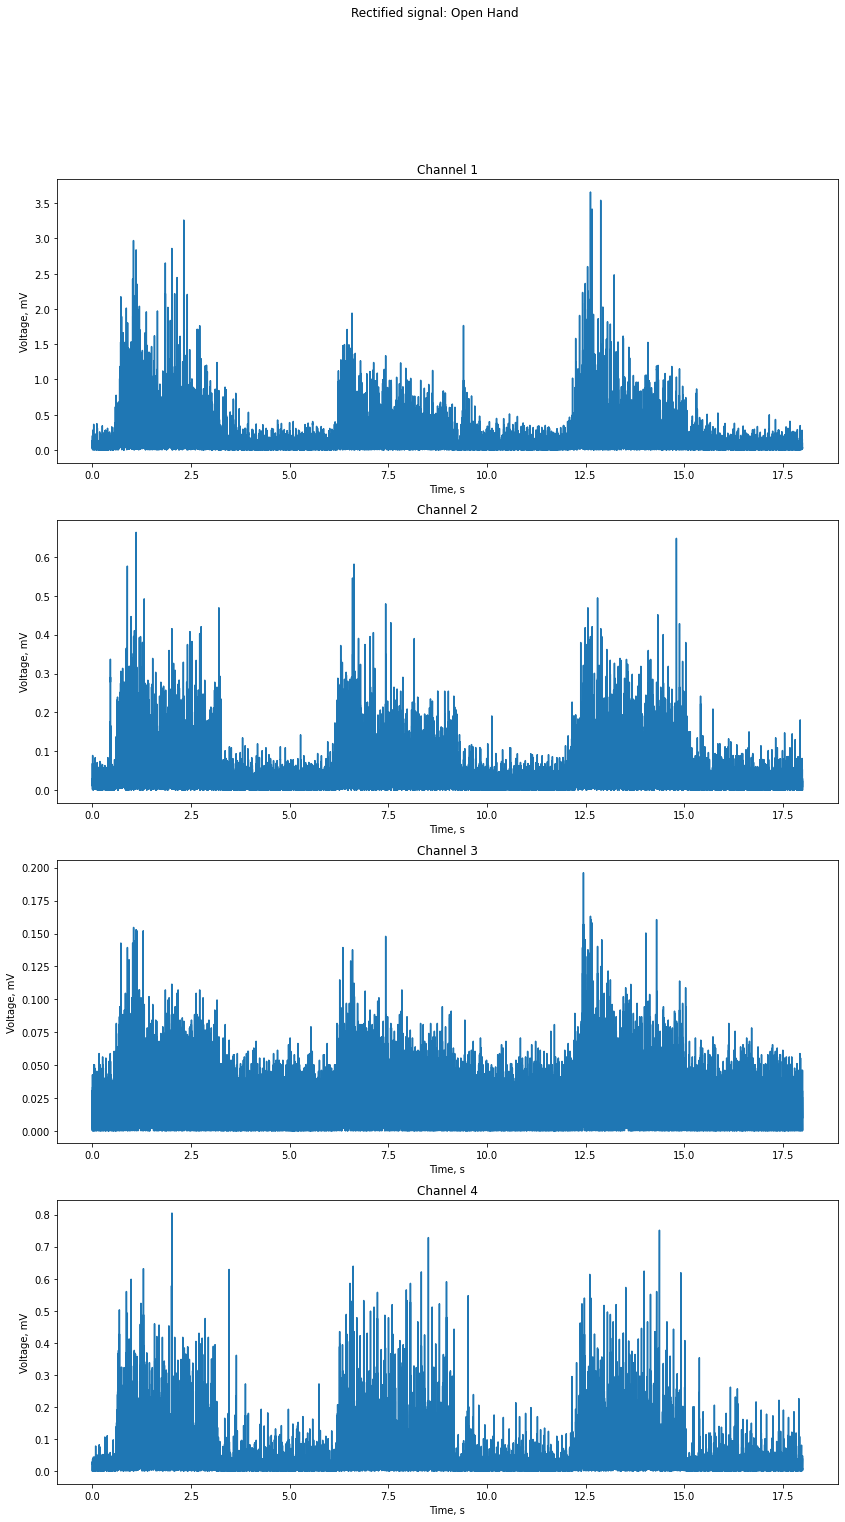

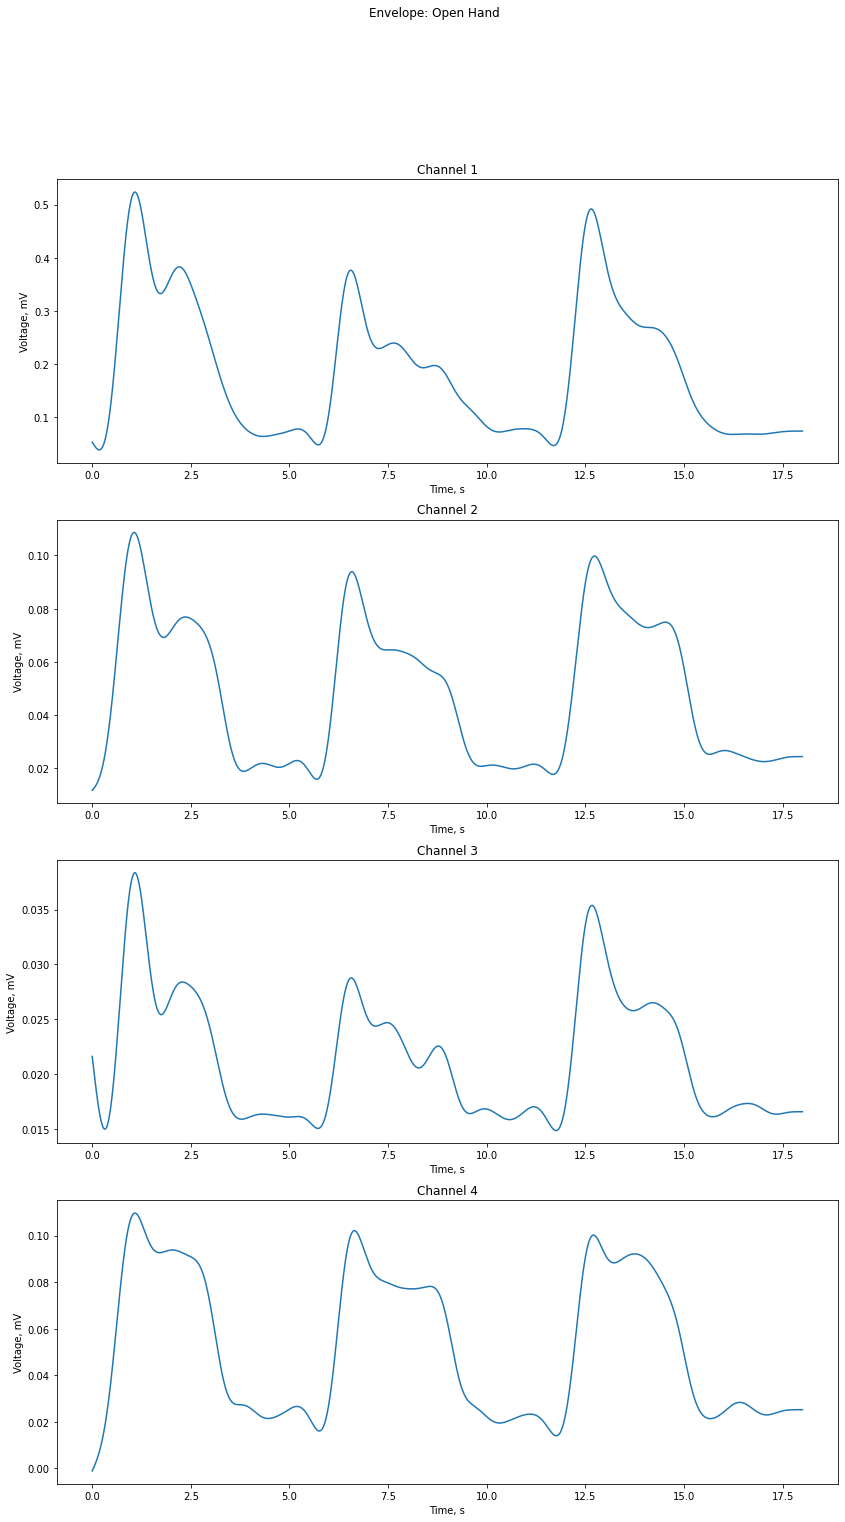

In [199]:
time = np.arange(0, sT, 1/sF) 
test_signal = movements_dictionary['Open Hand']
processing_pipeline(test_signal, time, 'Open Hand', sF, 1, visualize=True)

### Movement classification.

Libraries for AI part of the project.

In [308]:
import os
from sklearn.model_selection import train_test_split 
import torch
import torch.nn as nn
import torch.nn.functional as F

Using the processed signal data, I will train a model to recognize available movements.

I will use a whole BioPatRec dataset https://github.com/biopatrec/biopatrec/tree/Data_Repository/10mov4chForearmUntargeted.

In [307]:
!unzip -q biopatrec_10mov4chForearmUntargeted.zip

Reading and processing the whole dataset.

In [414]:
X = []
y = []

for filename in os.listdir("./10mov4chForearmUntargeted"):
    if filename.endswith(".mat"): 
        mat = loadmat("./10mov4chForearmUntargeted/" + filename)
        rec_session = mat['recSession']
        
        sF = rec_session['sF'][0][0][0][0]
        sT = rec_session['sT'][0][0][0][0]
        tdata = rec_session['tdata'][0][0]
        mov_labels = [el[0][0] for el in rec_session['mov'][0][0]]
        
        time = np.arange(0, sT, 1/sF) 
        for i in range(len(mov_labels)):
            X.append(np.concatenate(processing_pipeline(tdata[:, :, i].transpose(), time, sF, mov_labels[i], visualize=False)))
        
        y.extend([i for i in np.arange(10)])
        continue
    else:
        continue

Creating training and testing loaders.

In [415]:
class training_set(torch.utils.data.Dataset):
    def __init__(self,X,Y):
        self.X = X                           # set data
        self.Y = Y                           # set lables

    def __len__(self):
        return len(self.X)                   # return length

    def __getitem__(self, idx):
        return [self.X[idx], self.Y[idx]]

In [416]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

training_dataset = training_set(X_train, y_train)
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=50, shuffle=True)
print("Size of Training dataset:", len(training_dataset))

testing_dataset = training_set(X_test, y_test)
testing_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=50, shuffle=True)
print("Size of Testing dataset:", len(testing_dataset))

Size of Training dataset: 180
Size of Testing dataset: 20


Training an MLP (Multilayer Perceptron) model.

In [421]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer_1 = nn.Linear(144000, 100)
        self.layer_2 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = self.layer_1(x.float())
        x = self.layer_2(x)
        return x

In [424]:
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

epochs = 20

model.train()
for epoch in range(epochs):
    losses = []
    for batch_num, input_data in enumerate(train_loader):
        optimizer.zero_grad()
        x_var, y_var = input_data
        x_var = x_var.to(device).float()
        y_var = y_var.to(device)

        output = model(x_var)
        loss = criterion(output, y_var)
        loss.backward()
        losses.append(loss.item())

        optimizer.step()

        if batch_num % 40 == 0:
            print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
    print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))

	Epoch 0 | Batch 0 | Loss   2.30
Epoch 0 | Loss   7.37
	Epoch 1 | Batch 0 | Loss   6.34
Epoch 1 | Loss   6.51
	Epoch 2 | Batch 0 | Loss   4.49
Epoch 2 | Loss   4.73
	Epoch 3 | Batch 0 | Loss   3.56
Epoch 3 | Loss   3.14
	Epoch 4 | Batch 0 | Loss   3.12
Epoch 4 | Loss   3.52
	Epoch 5 | Batch 0 | Loss   2.28
Epoch 5 | Loss   2.56
	Epoch 6 | Batch 0 | Loss   2.79
Epoch 6 | Loss   2.35
	Epoch 7 | Batch 0 | Loss   1.73
Epoch 7 | Loss   1.52
	Epoch 8 | Batch 0 | Loss   1.30
Epoch 8 | Loss   1.37
	Epoch 9 | Batch 0 | Loss   1.40
Epoch 9 | Loss   1.30
	Epoch 10 | Batch 0 | Loss   1.19
Epoch 10 | Loss   1.04
	Epoch 11 | Batch 0 | Loss   1.00
Epoch 11 | Loss   0.92
	Epoch 12 | Batch 0 | Loss   0.95
Epoch 12 | Loss   0.82
	Epoch 13 | Batch 0 | Loss   0.94
Epoch 13 | Loss   0.91
	Epoch 14 | Batch 0 | Loss   0.65
Epoch 14 | Loss   0.90
	Epoch 15 | Batch 0 | Loss   0.62
Epoch 15 | Loss   0.77
	Epoch 16 | Batch 0 | Loss   0.94
Epoch 16 | Loss   0.84
	Epoch 17 | Batch 0 | Loss   0.77
Epoch 17 | Loss  

Model evaluation.

In [425]:
model.eval()
total_loss = 0
correct = 0

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(testing_loader):
        output = model(data)
        loss = F.cross_entropy(output, target) 
        total_loss += loss.item()
        correct += (output.argmax(1) == target).type(torch.float).sum().item()
        show_output = output.argmax(1)
        print(f"Expected   vs    Got")
        for i in range(len(target)):
            print(mov_labels[target[i]], "   ", mov_labels[show_output[i]])

print('Testing: Epoch average loss {:.6f}'.format(total_loss/len(testing_loader.dataset)))
print(f"         Accuracy: {(100*(correct/len(testing_loader.dataset))):>0.1f}%")

Expected   vs    Got
Side Grip     Agree
Flex Hand     Flex Hand
Pointer     Pointer
Supination     Fine Grip
Supination     Supination
Open Hand     Fine Grip
Supination     Pointer
Agree     Agree
Agree     Supination
Open Hand     Extend Hand
Agree     Fine Grip
Supination     Open Hand
Agree     Fine Grip
Side Grip     Fine Grip
Fine Grip     Fine Grip
Supination     Agree
Side Grip     Open Hand
Flex Hand     Flex Hand
Pronation     Pronation
Flex Hand     Flex Hand
Testing: Epoch average loss 0.122295
         Accuracy: 40.0%


Even tho final accuracy of the model is low, we still can see, some of the movements, which were predicted, are a little similar to the expected movement (for example, when I runned this code for Side Grip I got Fine Grip, which look a little similar)